- Psudo code follow Sutton's book
- **Advantage** should not calculate backprop
- [this](https://github.com/colinskow/move37/blob/master/pg/cartpole_pg.py#L135) add an extra entropy loss and log KL for each update too, good idea

In [20]:
%reload_ext autoreload
%autoreload 2
import sys
if "../" not in sys.path:
  sys.path.append("../") 
import torch
import numpy as np
import math
from EXITrl.trainer import Trainer
from EXITrl.nn_wrapper import NNWrapper
from EXITrl.helpers import get_simple_model, get_state_action_shape_from_env, convert_to_tensor, device
from EXITrl.constant import EPS
import gym
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

In [11]:
def generate_episode_follow_pi(env, policy):
    done = False
    episode_reward, reward = 0, 0
    state = env.reset()
    trajectory = []
    for i in range(1000):
        action, log_prob = policy(state)
        _state, reward, done, _ = env.step(action)
        trajectory.append((state, action, reward, done, log_prob))
        episode_reward += reward
        state = _state
        if done: break
    return episode_reward, trajectory

def get_total_reward(trajectory, gamma, is_normalize=True):
    returns = []
    G = 0
    for (_, _, reward, _, _) in trajectory[::-1]:
        # calculate the discounted value
        G = reward + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    if is_normalize:
        returns = (returns - returns.mean()) / (returns.std() + EPS)
    return returns 

### REINFORCE
- using Monte Carlo
- R. Sutton page 328
- REINFORCE : “REward Increment = Nonnegative Factor × Offset Reinforcement ×Characteristic Eligibility”
- [source](https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb) <br>
![image](../media/REINFORCE.png)

In [12]:
try: env.close()
except: pass
env = gym.make('CartPole-v1')

class REINFORCE(Trainer):
    def __init__(self, env, num_episodes, gamma, lr):
        super().__init__(env, num_episodes)
        state_shape, num_action = get_state_action_shape_from_env(env)
        
        model = get_simple_model(state_shape, 16, num_action)
        
        self.actor = NNWrapper(model=model, lr=lr)
        self.gamma = gamma
        
    def update(self, trajectory):
        loss = []
        total_rewards = get_total_reward(trajectory, self.gamma)
        for t in range(len(trajectory)):
            # this is old code with the same behavior
            # G = sum([self.gamma**k * reward for k, (state, reward, done, _) in enumerate(trajectory[t:])])
            G = total_rewards[t]
            _, _, _, _, log_prob = trajectory[t]
            # from Sutton's book said multiply by gamma**t 
            # but from David course no need too 
            # I tried both work
            
            # -log b/c we are trying to maximize reward but the algorithm using Gradient Descent
            # and actually it's not a 'loss' just the gradient of policy just write in term of pytorch loss
            loss.append(self.gamma**t * G * (-log_prob))
        self.actor.update(torch.stack(loss).sum())
    
    def _loop(self, episode) -> int:
        episode_reward, trajectory = generate_episode_follow_pi(env, self.actor.softmax_policy)
        self.update(trajectory)
        return episode_reward
        
    def _policy(self, state):
        action, log_prob = self.actor.softmax_policy(state)
        return action
    
s = REINFORCE(env, 
              num_episodes=500,
              gamma=.99,
              lr=1e-2)
s.train(True, early_stop=lambda reward: reward> env.spec.reward_threshold)


/Users/epinyoanun/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 10	Last reward: 15.00	Average reward: 20.00 	other{}                    
Episode 20	Last reward: 17.00	Average reward: 26.40 	other{}                    
Episode 30	Last reward: 19.00	Average reward: 24.00 	other{}                    
Episode 40	Last reward: 28.00	Average reward: 31.70 	other{}                    
Episode 50	Last reward: 36.00	Average reward: 34.20 	other{}                    
Episode 60	Last reward: 119.00	Average reward: 42.70 	other{}                    
Episode 70	Last reward: 32.00	Average reward: 45.90 	other{}                    
Episode 80	Last reward: 51.00	Average reward: 56.50 	other{}                    
Episode 90	Last reward: 61.00	Average reward: 63.40 	other{}                    
Episode 100	Last reward: 278.00	Average reward: 133.00 	other{}                    
Episode 110	Last reward: 92.00	Average reward: 140.10 	other{}                    
Epis

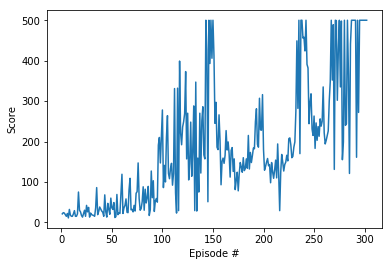

In [13]:
s.plot_rewards()

### REINFORCE with Baseline
I follow the Sutton's sudo code, (keep in mind, I possibly missunderstood)
![image](../media/REINFORCE_Baseline.png)

In [21]:
try: env.close()
except: pass
env = gym.make('CartPole-v1')

class REINFORCE_baseline(Trainer):
    def __init__(self, env, num_episodes, gamma):
        super().__init__(env, num_episodes)
        state_shape, num_action = get_state_action_shape_from_env(env)
        
        self.actor = NNWrapper(
                        model=get_simple_model(state_shape, 16, num_action), 
                        lr=1e-2)
        self.critic = NNWrapper(
                        model=get_simple_model(state_shape, 16, 1), 
                        lr=1e-2)
        self.gamma = gamma
        self.loss_value_fn = torch.nn.MSELoss(reduction='sum')
        
    def update(self, trajectory):
        values = []
        loss_policy = []
        td_targets = get_total_reward(trajectory, self.gamma)
        for t in range(len(trajectory)):
            state, action, reward, done, log_prob = trajectory[t]
            # .item to detatch the computation graph of the "advantage"
            td_error = td_targets[t] - self.critic.forward(state).item()
            
            values.append(self.critic.forward(state))
            loss_policy.append(self.gamma**t * td_error * (-log_prob))
            
        self.actor.update(torch.stack(loss_policy).sum())
        self.critic.update(
            self.loss_value_fn(
                torch.Tensor(td_targets), 
                torch.stack(values).squeeze()
            )
        )
    
    def _loop(self, episode) -> int:
        episode_reward, trajectory = generate_episode_follow_pi(env, self.actor.softmax_policy)
        self.update(trajectory)
        return episode_reward
    
    def _policy(self, state):
        action, log_prob = self.actor.softmax_policy(state)
        return action
    
s = REINFORCE_baseline(env, 
              num_episodes=500,
              gamma=.99)
s.train(True, early_stop=lambda reward: reward> env.spec.reward_threshold)


/Users/epinyoanun/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 10	Last reward: 22.00	Average reward: 24.70 	other{}                    
Episode 20	Last reward: 22.00	Average reward: 28.60 	other{}                    
Episode 30	Last reward: 24.00	Average reward: 31.30 	other{}                    
Episode 40	Last reward: 50.00	Average reward: 36.00 	other{}                    
Episode 50	Last reward: 51.00	Average reward: 37.20 	other{}                    
Episode 60	Last reward: 91.00	Average reward: 52.70 	other{}                    
Episode 70	Last reward: 28.00	Average reward: 49.80 	other{}                    
Episode 80	Last reward: 16.00	Average reward: 45.00 	other{}                    
Episode 90	Last reward: 59.00	Average reward: 52.30 	other{}                    
Episode 100	Last reward: 53.00	Average reward: 58.80 	other{}                    
Episode 110	Last reward: 44.00	Average reward: 52.90 	other{}                    
Episode 

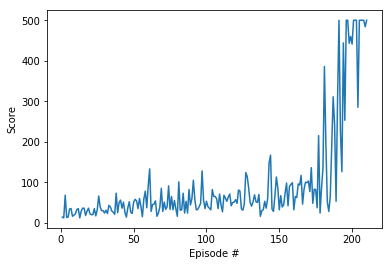

In [22]:
s.plot_rewards()

### A2C
![image](../media/Actor-Critic.png)

For this one, I follow "pytorch" example which is using share first layer of actor and critic, and seem like it's different from Sutton's book psudo code above
[source](https://github.com/pytorch/examples/blob/6c51ca5a614cfdbdcd4e8c3e70321c5f6defb177/reinforcement_learning/actor_critic.py)

- This is the same as the code before, REINFORCE with baseline but share the first layer of Actor Critic

In [4]:
class Model(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self, state, hidden, action):
        super(Model, self).__init__()
        self.feature = nn.Linear(state, hidden)
        self.action_head = nn.Linear(hidden, action)
        self.value_head = nn.Linear(hidden, 1)

    def forward(self, x):
        x = F.relu(self.feature(x))
        a = self.action_head(x)
        action_prob = F.softmax(self.action_head(x), dim=-1)
        state_values = self.value_head(x)
        return action_prob, state_values

class ActorCriticAgent:
    def __init__(self, lr, state, hidden, action):
        self.model = Model(state, hidden, action).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
    
    def policy(self, state):
        state = torch.from_numpy(state).float()
        probs, state_value = self.model(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), (m.log_prob(action), state_value)

    
    def update(self, loss):
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

In [5]:
try: env.close()
except: pass
env = gym.make('CartPole-v1')

class ActorCritic(Trainer):
    def __init__(self, env, num_episodes, gamma):
        super().__init__(env, num_episodes)
        state_shape, num_action = get_state_action_shape_from_env(env)
        
        self.agent = ActorCriticAgent(lr=3e-2, state=state_shape, hidden=128, action=num_action)
        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.agent.model.parameters(), lr=3e-2)
        
    def update(self, trajectory):
        policy_losses = [] # list to save actor (policy) loss
        values = []
        returns = get_total_reward(trajectory, self.gamma)

        for (_, _, _, _, (log_prob, value)), R in zip(trajectory, returns):
            advantage = R - value.item()
            policy_losses.append(-log_prob * advantage)
            values.append(value)

        # I spent the whole day to debug l1 function using 'average' as a default
        # From Pytorch example they use l1 but I use l2 (mse)
        loss = torch.stack(policy_losses).sum() + \
                F.mse_loss(torch.stack(values).squeeze(), returns, reduction='sum')
        self.agent.update(loss)
    
    def _loop(self, episode) -> int:
        episode_reward, trajectory = generate_episode_follow_pi(env, self.agent.policy)
        self.update(trajectory)
        return episode_reward
    
s = ActorCritic(env, 
              num_episodes=1000,
              gamma=.99)
s.train(True, early_stop=lambda reward: reward> env.spec.reward_threshold)


/Users/epinyoanun/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 10	Last reward: 12.00	Average reward: 20.50 	other{}                    
Episode 20	Last reward: 17.00	Average reward: 11.50 	other{}                    
Episode 30	Last reward: 29.00	Average reward: 24.90 	other{}                    
Episode 40	Last reward: 11.00	Average reward: 42.00 	other{}                    
Episode 50	Last reward: 21.00	Average reward: 17.90 	other{}                    
Episode 60	Last reward: 35.00	Average reward: 32.00 	other{}                    
Episode 70	Last reward: 60.00	Average reward: 59.70 	other{}                    
Episode 80	Last reward: 97.00	Average reward: 83.20 	other{}                    
Episode 90	Last reward: 66.00	Average reward: 107.10 	other{}                    
Episode 100	Last reward: 26.00	Average reward: 40.10 	other{}                    
Episode 110	Last reward: 171.00	Average reward: 60.70 	other{}                    
Episod

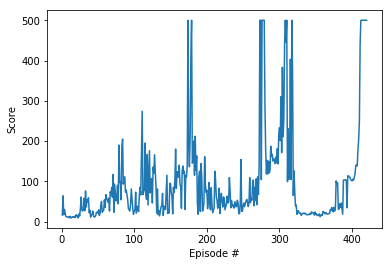

In [6]:
s.plot_rewards()